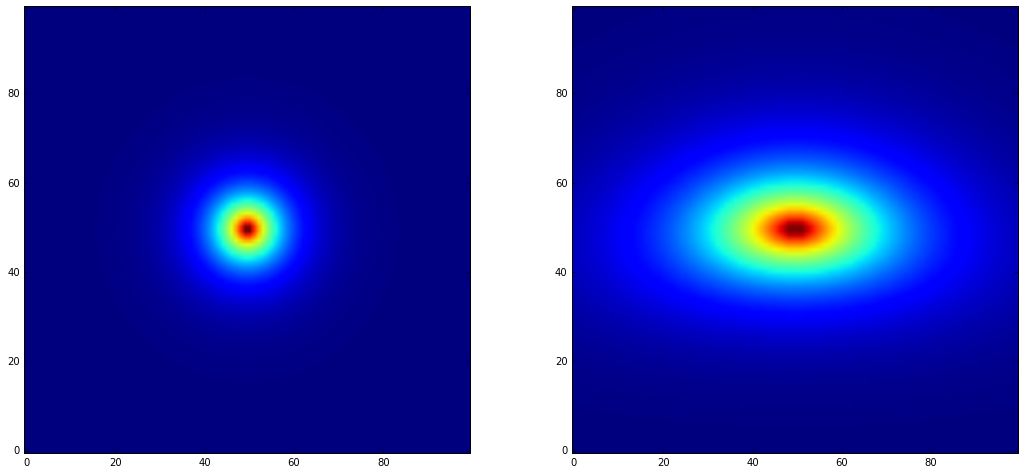

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class sersic(object):
    
    def __init__(self,side,N,**kwargs):
        
        if ('n' in kwargs):
            self.n=kwargs['n']
        else:
            self.n=4
            
        if ('re' in kwargs):
            self.re=kwargs['re']
        else:
            self.re=50.0
            
        if ('q' in kwargs):
            self.q=kwargs['q']
        else:
            self.q=1.0
            
        if ('pa' in kwargs):
            self.pa=kwargs['pa']
        else:
            self.pa=0.0
            
        if ('cx' in kwargs):
            self.cx=kwargs['cx']
        else:
            self.cx=0.0
            
        if ('cy' in kwargs):
            self.cy=kwargs['cy']
        else:
            self.cy=0.0
            
        self.N=N
        self.side=side
        
        # define the pixel coordinates 
        pc=np.linspace(-side/2.0,side/2.0,N)
        X,Y = np.meshgrid(pc,pc)
        x = np.cos(self.pa)*(X-self.cx)+np.sin(self.pa)*(Y-self.cy)
        y = -np.sin(self.pa)*(X-self.cx)+np.cos(self.pa)*(Y-self.cy)
        r = np.sqrt((x/self.q)**2+y**2)
        
        # profile
        bn = 1.992*self.n - 0.3271
        self.unlensed_frame = np.exp(-bn*((r/self.re)**(1.0/self.n)-1.0))

        self.X=X
        self.Y=Y

    def lens(self,**kwargs):
        if ('kappa' in kwargs):
            self.kappa = kwargs['kappa']
        else:
            self.kappa=0.0
            
        if ('gamma1' in kwargs):
            self.gamma1 = kwargs['gamma1']
        else:
            self.gamma1=0.0
            
        if ('gamma2' in kwargs):
            self.gamma2 = kwargs['gamma2']
        else:
            self.gamma2=0.0
            
        if ('g1' in kwargs):
            self.g1 = kwargs['g1']
        else:
            self.g1=0.0
        if ('g2' in kwargs):
            self.g2 = kwargs['g2']
        else:
            self.g2=0.0
            
        if ('f1' in kwargs):
            self.f1 = kwargs['f1']
        else:
            self.f1=0.0
        if ('f2' in kwargs):
            self.f2 = kwargs['f2']
        else:
            self.f2=0.0            

        a11=1.0-self.kappa-self.gamma1
        a22=1.0-self.kappa+self.gamma1
        a12=-self.gamma2
        a111=-0.5*(self.g1+3*self.f1)
        a222=-0.5*(3*self.f2-self.g2)
        a112=-0.5*(self.f2+self.g2)
        a221=-0.5*(self.f1-self.g1)

        b1 = a11*self.X + a12*self.Y + 0.5*a111*self.X**2 + a112*self.X*self.Y + 0.5*a221*self.Y**2 #Create lensed coordinate x matrix
        b2 = a22*self.Y + a12*self.X + 0.5*a222*self.Y**2 + a221*self.X*self.Y + 0.5*a112*self.X**2 #Create lensed coordinate y matrix
        
        #Linear interpolation scheme
        self.lensed_frame = self.__linearInterpolate(self.side,self.N,b1,b2,self.unlensed_frame)  
        fig,ax=plt.subplots(1,2,figsize=(18,8))
        ax[0].imshow(self.unlensed_frame,origin='lower')
        ax[1].imshow(self.lensed_frame,origin='lower')
        

    def __linearInterpolate(self,xmax,N,xb,yb,betaImg):

        #Background flux of image
        betaMin=betaImg.min()
        thetaImg=np.zeros((N,N))

        dx = 2.0*xmax/N #Axis division length

        i1 = (N*(xb+xmax)/(2.0*xmax)-0.5).astype(int) #Closest index value of lensed coordinates in x
        j1 = (N*(yb+xmax)/(2.0*xmax)-0.5).astype(int) #Closest index value of lensed coordinates in y

        xc = -xmax+2.0*xmax/N*(i1+0.5) #Coordinate position of the closest index value in x
        yc = -xmax+2.0*xmax/N*(j1+0.5) #Coordinate position of the closest index value in y

        wx = 1.0 - (xb - xc)/dx #Difference between true coordinate position and index value position
        wy = 1.0 - (yb - yc)/dx #Weighting

        msk = (i1<0)|(j1<0)|(i1>=(N-1))|(j1>=(N-1)) #Mask to exclude index values located out of unlensed domain
        msk2 = ~msk #Inverse mask

        #Contribution to new cell from surrounding background cells
        a = j1[msk2]
        b = i1[msk2]
        beta1 = betaImg[a,b]
        beta2 = betaImg[a,b+1]
        beta3 = betaImg[a+1,b]
        beta4 = betaImg[a+1,b+1]

        #Add background cell contributions
        x = wx[msk2]
        y = wy[msk2]
        thetaImg[msk2] = x*y*beta1 + (1.-x)*y*beta2 + x*(1.-y)*beta3 + (1.-x)*(1.-y)*beta4

        #These excluded values use the minimum betaImg value
        thetaImg[msk] = betaMin
        
        return thetaImg

se=sersic(1,100,n=1,re=0.1,q=1.,pa=np.pi/2.)
#se.lens(gamma1=0.2,f1=0.3,g2=0.5)
se.lens(gamma1=0.3,f2=0.2,g2=-0.5)
        
        